In [1]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install seqeval
! pip install sklearn_crfsuite

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6h2nq7fa
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6h2nq7fa
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=0f65a7c0184d63bc3990940ee46f51a506a50f90ada2ba694dee58abaa4f2f7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyvni1_d/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=7c287093ad2b8f844874e405674dcf5031f08f8e2335793bca9da401b4af1c5e
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 747kB 11.4MB/s 


In [2]:
import pandas as pd 
import numpy as np
from math import nan
from future.utils import iteritems
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
#loading train data
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive//My Drive/entity_train.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19,20,24,25,32,33,47,48,49,50,51,52,53,54,60,61,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df[285:295]

,Sentence ID,type,CUI,Preferred name,Semantic Type,Text,Confidence Score,First char pos,Last char pos,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
285,29.0,entity,C0042345,Varicosity,dsyn,varicosities,1000,3857,3869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,29.0,entity,C0013604,Edema,sosy,edema,1000,3873,3878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,29.0,entity,C0034107,Pulse taking,hlca,pulses,1000,3883,3889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,29.0,entity,C0205163,Equal,qlco,equal,1000,3902,3907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,29.0,entity,C0443225,Full,qlco,full,888,3911,3915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,29.0,entity,C0439792,Extent,spco,extent,888,3916,3922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,29.0,entity,C0015385,Limb structure,bpoc,extremities,1000,3930,3941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,30.0,text,3943,4035,"Neurologically , the patient was alert and ori...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,30.0,entity,C0030705,Patients,podg,patient,1000,3964,3971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df1=df[['type','Sentence ID','Text','Semantic Type']]

df1=df1[df1['type']=='entity']  #We take only the entities i.e. removing the text and relation types

df1=df1[['Sentence ID','Text','Semantic Type']]

df1=df1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

In [6]:
df1[285:295]

,sentence_idx,word,tag
374,37.0,coronary arteries,bpoc
375,37.0,left,spco
376,37.0,radial artery,bpoc
377,37.0,right coronary,blor
378,37.0,artery,bpoc
382,38.0,Significant,qnco
383,38.0,times,tmco
384,38.0,operation,topp
385,38.0,cardiopulmonary bypass time,fndg
386,38.0,minutes,tmco


In [7]:
#loading test data
from google.colab import drive
drive.mount('/content/drive')
dftest=pd.read_csv('/content/drive//My Drive/entity_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dftest[285:295]

,Sentence ID,type,CUI,Preferred name,Semantic Type,Text,Confidence Score,First char pos,Last char pos,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
285,49.0,entity,C0205307,Normal,qlco,normal,888.0,3409.0,3415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,49.0,entity,C0033572,Prostate,bpoc,prostate,888.0,3416.0,3424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,50.0,text,3427,3507,His neurological examination was remarkable fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,50.0,entity,C0027853,Neurologic Examination,diap,neurological examination,1000.0,3431.0,3455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,50.0,entity,C0750532,MILDLY,idcn,mildly,828.0,3477.0,3483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,50.0,entity,C0085584,Encephalopathies,dsyn,encephalopathic,828.0,3484.0,3499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,50.0,entity,C0086582,Males,orga,male,828.0,3500.0,3504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,51.0,text,3507,3535,He was oriented times two .,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dftest1=dftest[['type','Sentence ID','Text','Semantic Type']]

dftest1=dftest1[dftest1['type']=='entity']  #We take only the entities i.e. removing the text and relation

dftest1=dftest1[['Sentence ID','Text','Semantic Type']]

dftest1=dftest1.rename(columns={'Sentence ID':'sentence_idx','Text':'word','Semantic Type':'tag'})

In [10]:
dftest1[285:295]

,sentence_idx,word,tag
429,67.0,time,tmco
430,67.0,face,blor
431,67.0,40 percent face mask,qnco
434,68.0,hematocrit,lbpr
435,68.0,time,tmco
438,69.0,guaiac positive,lbtr
439,69.0,time,tmco
442,70.0,mental status,fndg
445,71.0,patient,podg
446,71.0,well,qlco


In [0]:
###creating sentence id

#for train data

index_train=df1.index


seq_train=[]
seq_train.append(df1['sentence_idx'][index_train[0]])
for i in range(1,len(index_train)):
  seq_train.append(df1['sentence_idx'][index_train[i]]-df1['sentence_idx'][index_train[i-1]])
len(seq_train)


neg_ind_train=[]
for i in range(len(seq_train)):
  if seq_train[i]<0:
    seq_train[i]=1
    neg_ind_train.append(i)

df1=df1.assign(ind_train=seq_train)
sen_id=df1['ind_train'].cumsum()
df1=df1.assign(sentence_idx=sen_id)
df1=df1.drop('ind_train',1)
df1=df1.dropna()

In [12]:
df1[285:295]

,sentence_idx,word,tag
374,37.0,coronary arteries,bpoc
375,37.0,left,spco
376,37.0,radial artery,bpoc
377,37.0,right coronary,blor
378,37.0,artery,bpoc
382,38.0,Significant,qnco
383,38.0,times,tmco
384,38.0,operation,topp
385,38.0,cardiopulmonary bypass time,fndg
386,38.0,minutes,tmco


In [13]:
df1.head()

,sentence_idx,word,tag
1,1.0,RECORD,inpr
2,1.0,10/2006 12,fndg
3,1.0,CORONARY ARTERY DISEASE,dsyn
4,1.0,Signed,inpr
5,1.0,DIS,inpr


In [14]:
df1.tail()

,sentence_idx,word,tag
397346,55259.0,outpatient,podg
397347,55259.0,cardiologist,prog
397350,55260.0,document,inpr
397351,55260.0,Tel,gngm
397352,55260.0,end,spco


In [0]:
#creating sentence id for test data

index_test=dftest1.index


seq_test=[]
seq_test.append(dftest1['sentence_idx'][index_test[0]])
for i in range(1,len(index_test)):
  seq_test.append(dftest1['sentence_idx'][index_test[i]]-dftest1['sentence_idx'][index_test[i-1]])
len(seq_test)


neg_ind_test=[]
for i in range(len(seq_test)):
  if seq_test[i]<0:
    seq_test[i]=1
    neg_ind_test.append(i)

dftest1=dftest1.assign(ind_test=seq_test)
sen_id=dftest1['ind_test'].cumsum()
dftest1=dftest1.assign(sentence_idx=sen_id)
dftest1=dftest1.drop('ind_test',1)
dftest1=dftest1.dropna()

In [16]:
dftest1[285:295]

,sentence_idx,word,tag
429,67.0,time,tmco
430,67.0,face,blor
431,67.0,40 percent face mask,qnco
434,68.0,hematocrit,lbpr
435,68.0,time,tmco
438,69.0,guaiac positive,lbtr
439,69.0,time,tmco
442,70.0,mental status,fndg
445,71.0,patient,podg
446,71.0,well,qlco


In [17]:
dftest1.head()

,sentence_idx,word,tag
1,1.0,ROOT,plnt
2,1.0,RECORD,inpr
3,1.0,ID,dsyn
4,1.0,TEXT,inpr
5,1.0,FIH,dsyn


In [18]:
dftest1.tail()

,sentence_idx,word,tag
245376,34801.0,M.D,inpr
245379,34802.0,end,spco
245380,34802.0,TEXT,inpr
245381,34802.0,RECORD,inpr
245382,34802.0,ROOT,plnt


In [0]:
#Split test data into 2 half
test_sp1, test_sp2 = train_test_split(dftest1, test_size=0.5,random_state=123)

In [20]:
max(df1['sentence_idx'])

55260.0

In [21]:
max(dftest1['sentence_idx'])

34802.0

In [0]:
dftest_sp1=test_sp1.sort_index(axis = 0)	# sort by index labels

In [0]:
dfdev1, test_sp = train_test_split(test_sp2, test_size=0.5,random_state=123)	#Split other half test data into dev and test data
dfdev1=dfdev1.sort_index(axis=0)
test_sp=test_sp.sort_index(axis=0)
dftest1=test_sp

In [24]:
dftest1[285:295]

,sentence_idx,word,tag
1922,315.0,years,tmco
1926,315.0,ever,tmco
1934,316.0,dynamic,ftcn
1935,316.0,compression,ftcn
1946,318.0,ALLERGIES,patf
1960,320.0,Insulin NPH,"aapp,horm,phsu"
1965,321.0,units,qnco
1968,322.0,Zestril,"aapp,phsu"
1976,325.0,day,tmco
1990,329.0,Percocet 1-2 tablets,clnd


In [25]:
dfdev1[285:295]

,sentence_idx,word,tag
1774,294.0,outpatient,podg
1785,296.0,breath,bdsu
1796,298.0,medication,phsu
1804,299.0,medication,phsu
1807,300.0,M.D,inpr
1822,303.0,RECORD,inpr
1834,304.0,UNIT,qnco
1837,304.0,DISCHARGE DATE,tmco
1840,304.0,left,spco
1841,304.0,total,qnco


In [27]:
dftest_sp1[285:295]

,sentence_idx,word,tag
816,123.0,throat,bpoc
819,123.0,ulcers,dsyn
826,125.0,Neck,blor
827,125.0,supple,ftcn
828,125.0,lungs,bpoc
830,125.0,scattered,spco
833,126.0,Cardiac,bpoc
834,126.0,tachycardic,fndg
838,127.0,Belly,plnt
839,127.0,right upper quadrant,spco


In [28]:
#Taking only required tags and the rest renamed as others 'O'
tag_req=['diap','fndg','lbpr','lbtr']
df2=df1[df1.tag.str.contains('|'.join(tag_req))]

req_train=df2.index

for i in df1.index:
  if i not in req_train:
    df1.tag[i]='O'
  else:
    if ',' in df1.tag[i]:
      df1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [29]:
dftest2=dftest1[dftest1.tag.str.contains('|'.join(tag_req))]

req_test=dftest2.index

for i in dftest1.index:
  if i not in req_test:
    dftest1.tag[i]='O'
  else:
    if ',' in dftest1.tag[i]:
      dftest1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
dfdev2=dfdev1[dfdev1.tag.str.contains('|'.join(tag_req))]

req_dev=dfdev2.index

for i in dfdev1.index:
  if i not in req_dev:
    dfdev1.tag[i]='O'
  else:
    if ',' in dfdev1.tag[i]:
      dfdev1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [31]:
dftest_sp2=dftest_sp1[dftest_sp1.tag.str.contains('|'.join(tag_req))]

req_test_sp=dftest_sp2.index

for i in dftest_sp1.index:
  if i not in req_test_sp:
    dftest_sp1.tag[i]='O'
  else:
    if ',' in dftest_sp1.tag[i]:
      dftest_sp1.tag[i]='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
df1[285:295]

,sentence_idx,word,tag
374,37.0,coronary arteries,O
375,37.0,left,O
376,37.0,radial artery,O
377,37.0,right coronary,O
378,37.0,artery,O
382,38.0,Significant,O
383,38.0,times,O
384,38.0,operation,O
385,38.0,cardiopulmonary bypass time,fndg
386,38.0,minutes,O


In [34]:
dftest1[780:790]

,sentence_idx,word,tag
4897,799.0,anemia,O
4898,799.0,hematocrit,lbpr
4900,799.0,microcytic,fndg
4906,800.0,positive,O
4913,801.0,chest,O
4919,802.0,Liver,O
4929,804.0,tomographic,diap
4932,804.0,thickening,fndg
4936,804.0,lesser,O
4942,805.0,thickening,fndg


In [35]:
dfdev1[200:210]

,sentence_idx,word,tag
1253,191.0,chemotherapy,O
1258,192.0,head CT,diap
1269,194.0,echocardiogram,diap
1281,196.0,symptoms,O
1282,196.0,dyspnea,O
1290,198.0,Schizoaffective disorder,O
1304,203.0,ALLERGIES,O
1307,204.0,Penicillin,O
1321,208.0,Erythromycin,O
1328,210.0,Talwin,O


In [36]:
dftest_sp1[780:790]

,sentence_idx,word,tag
2359,404.0,diet,O
2364,405.0,dislocation,O
2365,405.0,precautions,O
2372,406.0,point,O
2375,407.0,INR,lbpr
2377,407.0,results,O
2383,409.0,Goal,O
2384,409.0,INR,lbpr
2385,409.0,1.5,O
2386,409.0,Coumadin,O


In [0]:
#BIO-tagging For Train Data
temp01=pd.DataFrame(df1.word.str.split().tolist(), index=df1['sentence_idx']).stack()
d1 = temp01.index
t1 = []
for i in range(len(d1)):
  if d1[i][1] == 0:
    t1.append('B-')
  else:
    t1.append('I-')
temp01 = temp01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp01.columns = ['word','sentence_idx']
temp01=temp01[['sentence_idx','word']]
temp01=temp01.assign(bio_tr=t1)

temp02=pd.DataFrame(df1.word.str.split().tolist(), index=df1['tag']).stack()
temp02 = temp02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp02.columns = ['word','tag']

temp01["tag"] = temp01["bio_tr"].astype(str) + temp02["tag"]
del temp01['bio_tr']
temp01['tag']=temp01['tag'].replace(['B-O','I-O'],'O')

df1=temp01

In [40]:
df1[1005:1015]

,sentence_idx,word,tag
1005,106.0,old,O
1006,106.0,white,O
1007,106.0,male,O
1008,106.0,recent,B-fndg
1009,106.0,myocardial,I-fndg
1010,106.0,infarction,I-fndg
1011,106.0,recurrent,O
1012,106.0,chest,O
1013,106.0,discomfort,O
1014,107.0,July,O


In [0]:
#BIO-tagging For Test Data
temp_test01=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['sentence_idx']).stack()
d1_test = temp_test01.index
t1_test = []
for i in range(len(d1_test)):
  if d1_test[i][1] == 0:
    t1_test.append('B-')
  else:
    t1_test.append('I-')
temp_test01 = temp_test01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_test01.columns = ['word','sentence_idx']
temp_test01=temp_test01[['sentence_idx','word']]
temp_test01=temp_test01.assign(bio_te=t1_test)

temp_test02=pd.DataFrame(dftest1.word.str.split().tolist(), index=dftest1['tag']).stack()
temp_test02 = temp_test02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_test02.columns = ['word','tag']

temp_test01["tag"] = temp_test01["bio_te"].astype(str) + temp_test02["tag"]
del temp_test01['bio_te']
temp_test01['tag']=temp_test01['tag'].replace(['B-O','I-O'],'O')

dftest1=temp_test01

In [42]:
dftest1[285:295]

,sentence_idx,word,tag
285,240.0,Metabolic,B-lbpr
286,240.0,20,I-lbpr
287,240.0,panel,I-lbpr
288,240.0,unremarkable,O
289,241.0,unremarkable,O
290,242.0,normal,B-fndg
291,242.0,sinus,I-fndg
292,242.0,rhythm,I-fndg
293,243.0,patient,O
294,245.0,time,O


In [0]:
#BIO-tagging For dev Data
temp_dev01=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['sentence_idx']).stack()
d1_dev = temp_dev01.index
t1_dev = []
for i in range(len(d1_dev)):
  if d1_dev[i][1] == 0:
    t1_dev.append('B-')
  else:
    t1_dev.append('I-')
temp_dev01 = temp_dev01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_dev01.columns = ['word','sentence_idx']
temp_dev01=temp_dev01[['sentence_idx','word']]
temp_dev01=temp_dev01.assign(bio_te=t1_dev)

temp_dev02=pd.DataFrame(dfdev1.word.str.split().tolist(), index=dfdev1['tag']).stack()
temp_dev02 = temp_dev02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_dev02.columns = ['word','tag']

temp_dev01["tag"] = temp_dev01["bio_te"].astype(str) + temp_dev02["tag"]
del temp_dev01['bio_te']
temp_dev01['tag']=temp_dev01['tag'].replace(['B-O','I-O'],'O')

dfdev1=temp_dev01

In [44]:
dfdev1[285:295]

,sentence_idx,word,tag
285,224.0,SOCIAL,B-fndg
286,224.0,HISTORY,I-fndg
287,225.0,boyfriend,O
288,226.0,siblings,O
289,227.0,patient,O
290,227.0,20,O
291,227.0,pack,O
292,227.0,smoking,B-fndg
293,227.0,history,I-fndg
294,229.0,drug,O


In [0]:
#BIO-tagging For test split1 Data
temp_test_sp01=pd.DataFrame(dftest_sp1.word.str.split().tolist(), index=dftest_sp1['sentence_idx']).stack()
d1_test_sp = temp_test_sp01.index
t1_test_sp = []
for i in range(len(d1_test_sp)):
  if d1_test_sp[i][1] == 0:
    t1_test_sp.append('B-')
  else:
    t1_test_sp.append('I-')
temp_test_sp01 = temp_test_sp01.reset_index()[[0, 'sentence_idx']] # 'word' variable is currently labeled 0
temp_test_sp01.columns = ['word','sentence_idx']
temp_test_sp01=temp_test_sp01[['sentence_idx','word']]
temp_test_sp01=temp_test_sp01.assign(bio_te=t1_test_sp)

temp_test_sp02=pd.DataFrame(dftest_sp1.word.str.split().tolist(), index=dftest_sp1['tag']).stack()
temp_test_sp02 = temp_test_sp02.reset_index()[[0, 'tag']] # 'word' variable is currently labeled 0
temp_test_sp02.columns = ['word','tag']

temp_test_sp01["tag"] = temp_test_sp01["bio_te"].astype(str) + temp_test_sp02["tag"]
del temp_test_sp01['bio_te']
temp_test_sp01['tag']=temp_test_sp01['tag'].replace(['B-O','I-O'],'O')

dftest_sp1=temp_test_sp01

In [46]:
dftest_sp1[285:295]

,sentence_idx,word,tag
285,96.0,blood,O
286,96.0,cells,O
287,97.0,mental,B-fndg
288,97.0,status,I-fndg
289,99.0,head,B-diap
290,99.0,computerized,I-diap
291,99.0,tomography,I-diap
292,99.0,right,O
293,99.0,right,O
294,99.0,middle,O


In [0]:
train=df1
test=dftest1
dev=dfdev1
train2=dftest_sp1

In [0]:
#Define Sentence Getter
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
#Sentence getter for train
getter_train = SentenceGetter(train)
sentences_train = getter_train.sentences

#Sentence getter for test
getter_test = SentenceGetter(test)
sentences_test = getter_test.sentences

#Sentence getter for dev
getter_dev = SentenceGetter(dev)
sentences_dev = getter_dev.sentences

#Sentence getter for train2
getter_train2 = SentenceGetter(train2)
sentences_train2 = getter_train2.sentences

In [51]:
sentences_train2[100:110]

[[('MEDICATIONS', 'O')],
 [('ALLERGIES', 'O')],
 [('Lives', 'B-fndg')],
 [('brandy', 'O'), ('cigar', 'O'), ('smoker', 'O'), ('years', 'O')],
 [('97', 'O'),
  ('vital', 'O'),
  ('signs', 'O'),
  ('head', 'O'),
  ('eyes', 'O'),
  ('ears', 'O'),
  ('throat', 'O'),
  ('ulcers', 'O')],
 [('Neck', 'O'), ('supple', 'O'), ('lungs', 'O'), ('scattered', 'O')],
 [('Cardiac', 'O'), ('tachycardic', 'B-fndg')],
 [('Belly', 'O'), ('right', 'O'), ('upper', 'O'), ('quadrant', 'O')],
 [('Liver', 'B-fndg'), ('edge', 'I-fndg'), ('wall', 'O'), ('palpable', 'O')],
 [('inguinal', 'O'), ('nodes', 'O')]]

In [0]:
##formation of words and tags

#for train

words_train = list(set(train["word"].values))
n_words_train = len(words_train)

tags_train = []
for tag in set(train["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_train.append('unk')
    else:
        tags_train.append(tag)
n_tags_train = len(tags_train)

#for test
words_test = list(set(test["word"].values))
n_words_test = len(words_test)

tags_test = []
for tag in set(test["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_test.append('unk')
    else:
        tags_test.append(tag)
n_tags_test = len(tags_test)

#for dev
words_dev = list(set(dev["word"].values))
n_words_dev = len(words_dev)

tags_dev = []
for tag in set(dev["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_dev.append('unk')
    else:
        tags_dev.append(tag)
n_tags_dev = len(tags_dev)

#for train2
words_train2 = list(set(train2["word"].values))
n_words_train2 = len(words_train2)

tags_train2 = []
for tag in set(train2["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags_train2.append('unk')
    else:
        tags_train2.append(tag)
n_tags_train2 = len(tags_train2)

In [0]:
#taking union of train, dev and test

words_all = list(set().union(words_train,words_test,words_dev,words_train2))
n_words_all = len(words_all)

tags_all = list(set().union(tags_train,tags_test,tags_dev,tags_train2))
n_tags_all = len(tags_all)

In [0]:
##formation of word2id, tag2id and id2tag

#for all union of train and test
word2idx_all = {w: i for i, w in enumerate(words_all)}
tag2idx_all = {t: i for i, t in enumerate(tags_all)}
idx2tag_all = {v: k for k, v in iteritems(tag2idx_all)}

maxlen_all = max(max([len(s) for s in sentences_train]),max([len(s) for s in sentences_test]),max([len(s) for s in sentences_dev]),max([len(s) for s in sentences_train2]))

In [68]:
words_all[25:35]

['Sirolimus',
 'sulfonylurea',
 'hematemesis',
 'VALUES',
 'otolaryngologist',
 'bacteremia',
 'nephrologist',
 'apex',
 'Smooth',
 'structures']

In [69]:
tags_all

['B-lbpr',
 'B-diap',
 'I-lbpr',
 'I-diap',
 'I-fndg',
 'O',
 'I-lbtr',
 'B-fndg',
 'B-lbtr']

In [70]:
tag2idx_all

{'B-diap': 1,
 'B-fndg': 7,
 'B-lbpr': 0,
 'B-lbtr': 8,
 'I-diap': 3,
 'I-fndg': 4,
 'I-lbpr': 2,
 'I-lbtr': 6,
 'O': 5}

In [71]:
idx2tag_all

{0: 'B-lbpr',
 1: 'B-diap',
 2: 'I-lbpr',
 3: 'I-diap',
 4: 'I-fndg',
 5: 'O',
 6: 'I-lbtr',
 7: 'B-fndg',
 8: 'B-lbtr'}

In [0]:
##vectorisation

#for train

maxlen_train = max([len(s) for s in sentences_train])

X_train = [[word2idx_all[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=maxlen_all, sequences=X_train, padding="post",value=n_words_all - 1)

y_train = [[tag2idx_all[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=maxlen_all, sequences=y_train, padding="post", value=tag2idx_all["O"])
y_train = [to_categorical(i, num_classes=n_tags_all) for i in y_train]


#for test
maxlen_test = max([len(s) for s in sentences_test])

X_test = [[word2idx_all[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=maxlen_all, sequences=X_test, padding="post",value=n_words_all - 1)

y_test = [[tag2idx_all[w[1]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=maxlen_all, sequences=y_test, padding="post", value=tag2idx_all["O"])
y_test = [to_categorical(i, num_classes=n_tags_all) for i in y_test]

#for dev
maxlen_dev = max([len(s) for s in sentences_dev])

X_dev = [[word2idx_all[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen=maxlen_all, sequences=X_dev, padding="post",value=n_words_all - 1)

y_dev = [[tag2idx_all[w[1]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen=maxlen_all, sequences=y_dev, padding="post", value=tag2idx_all["O"])
y_dev = [to_categorical(i, num_classes=n_tags_all) for i in y_dev]

#for train2
maxlen_train2 = max([len(s) for s in sentences_train2])

X_train2 = [[word2idx_all[w[0]] for w in s] for s in sentences_train2]
X_train2 = pad_sequences(maxlen=maxlen_all, sequences=X_train2, padding="post",value=n_words_all - 1)

y_train2 = [[tag2idx_all[w[1]] for w in s] for s in sentences_train2]
y_train2 = pad_sequences(maxlen=maxlen_all, sequences=y_train2, padding="post", value=tag2idx_all["O"])
y_train2 = [to_categorical(i, num_classes=n_tags_all) for i in y_train2]

In [73]:
X_train2

array([[16770, 20699,  9282, ..., 21447, 21447, 21447],
       [ 6486,  4576,  2481, ..., 21447, 21447, 21447],
       [ 2981,    27, 16205, ..., 21447, 21447, 21447],
       ...,
       [14247, 21447, 21447, ..., 21447, 21447, 21447],
       [14247, 21447, 21447, ..., 21447, 21447, 21447],
       [ 4404, 20699, 21447, ..., 21447, 21447, 21447]], dtype=int32)

In [74]:
y_train2[0:3]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [0]:
##MODEL

input = Input(shape=(max(X_train.shape[1],X_dev.shape[1],X_test.shape[1],X_train2.shape[1]),))
word_embedding_size = 180

# Embedding Layer
model = Embedding(input_dim=n_words_all, output_dim=word_embedding_size, input_length=max(X_train.shape[1],X_dev.shape[1],X_test.shape[1],X_train2.shape[1]))(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags_all, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags_all)

out = crf(model)  # output
model = Model(input, out)

In [76]:
##FIT MODEL

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 274)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 274, 180)          3860640   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 274, 360)          519840    
_________________________________________________________________
lstm_2 (LSTM)                (None, 274, 360)          1038240   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 274, 9)            3249      
_________________________________________________________________
crf_1 (CRF)                  (None, 274, 9)            189       
Total params: 5,422,158
Trainable params: 5,422,158
Non-trainable params: 0
_________________________________________________

In [0]:
# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [78]:
# Fit the best model with train data
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=5, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44782 samples, validate on 4976 samples
Epoch 1/5
44782/44782 [==============================] - 343s 8ms/step - loss: 0.0836 - crf_viterbi_accuracy: 0.9806 - accuracy: 2.5916e-04 - val_loss: 0.0192 - val_crf_viterbi_accuracy: 0.9968 - val_accuracy: 0.9969

Epoch 00001: val_accuracy improved from -inf to 0.99686, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/5
44782/44782 [==============================] - 331s 7ms/step - loss: 0.0172 - crf_viterbi_accuracy: 0.9970 - accuracy: 2.5916e-04 - val_loss: 0.0155 - val_crf_viterbi_accuracy: 0.9968 - val_accuracy: 0.9969

Epoch 00002: val_accuracy did not improve from 0.99686
Epoch 3/5
44782/44782 [==============================] - 329s 7ms/step - loss: 0.0135 - crf_viterbi_accuracy: 0.9970 - accuracy: 2.5916e-04 - val_loss: 0.0117 - val_crf_viterbi_accuracy: 0.9970 - val_accuracy: 0.9970

Epoch 00003: val_accuracy improved from 0.99686 to 0.99698, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 4/5
44782/44782 [========

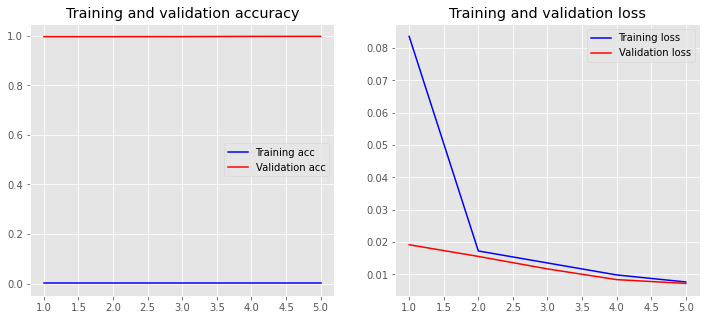

In [79]:
####PLOTS of loss and accuracy
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [80]:
# Fit the best model with train2 data
history = model.fit(X_train2, np.array(y_train2), batch_size=256, epochs=5, validation_data=(X_dev, np.array(y_dev)), verbose=1, callbacks=callbacks_list)

Train on 27810 samples, validate on 20655 samples
Epoch 1/5
27810/27810 [==============================] - 224s 8ms/step - loss: 0.0052 - crf_viterbi_accuracy: 0.9985 - accuracy: 1.1995e-04 - val_loss: 0.0028 - val_crf_viterbi_accuracy: 0.9991 - val_accuracy: 0.9991

Epoch 00001: val_accuracy improved from 0.99799 to 0.99905, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/5
27810/27810 [==============================] - 224s 8ms/step - loss: 0.0044 - crf_viterbi_accuracy: 0.9986 - accuracy: 1.1995e-04 - val_loss: 0.0025 - val_crf_viterbi_accuracy: 0.9991 - val_accuracy: 0.9991

Epoch 00002: val_accuracy improved from 0.99905 to 0.99909, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 3/5
27810/27810 [==============================] - 223s 8ms/step - loss: 0.0039 - crf_viterbi_accuracy: 0.9986 - accuracy: 1.1995e-04 - val_loss: 0.0022 - val_crf_viterbi_accuracy: 0.9991 - val_accuracy: 0.9991

Epoch 00003: val_accuracy improved from 0.99909 to 0.99910, saving model to ner-bi

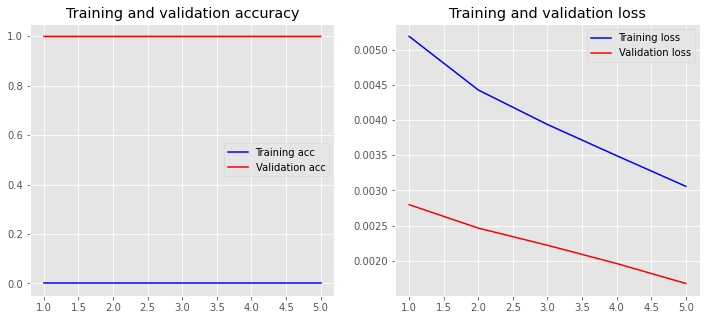

In [81]:
####PLOTS of loss and accuracy
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [82]:
####FIT with the TEST data
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag_all[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

20625/20625 [==============================] - 124s 6ms/step


In [83]:
#####REPORT of the fit

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

###Rest
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx_all.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag_all[gt[idx]],tags_all[pred])

for tag in tag2idx_all.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))

F1-score: 40.2%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      B-diap       0.00      0.00      0.00       878
      B-fndg       0.56      0.68      0.62      2971
      B-lbpr       0.00      0.00      0.00       443
      B-lbtr       0.00      0.00      0.00        59
      I-diap       0.00      0.00      0.00       470
      I-fndg       0.61      0.61      0.61      2520
      I-lbpr       0.00      0.00      0.00       208
      I-lbtr       0.00      0.00      0.00        72
           O       1.00      1.00      1.00   5643629

    accuracy                           1.00   5651250
   macro avg       0.24      0.25      0.25   5651250
weighted avg       1.00      1.00      1.00   5651250

tag:B-lbpr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-diap
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-lbpr
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-diap
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-fndg
